In [ ]:
import zipfile

import pandas as pd

In [ ]:
local_zip = '/content/drive/MyDrive/dataset/Emotions dataset for NLP _ Kaggle.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [ ]:
SENTIMENT_TXT = "train.txt"

with open(SENTIMENT_TXT, 'r') as f:
    print(f"First data point looks like this:\n\n{f.readline()}")
    print(f"Second data point looks like this:\n\n{f.readline()}")

First data point looks like this:

i didnt feel humiliated;sadness

Second data point looks like this:

i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake;sadness



In [ ]:
df = pd.read_csv(SENTIMENT_TXT, sep=";", header=None)
df.columns = ["sentences", "labels"]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentences  16000 non-null  object
 1   labels     16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB


<AxesSubplot:title={'center':'Count of label'}>

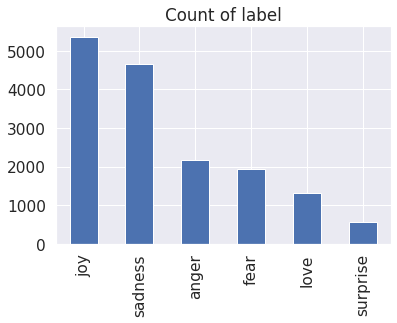

In [ ]:
df["labels"].value_counts().plot(kind='bar', title="Count of label")

<AxesSubplot:title={'center':'Histogram of review length'}, ylabel='Frequency'>

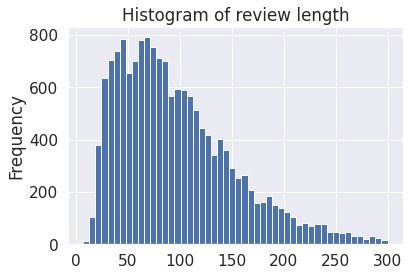

In [ ]:
df["sentences"].apply(len).plot(kind='hist', bins=50, title="Histogram of review length")

In [ ]:
# from imblearn.over_sampling import RandomOverSampler

# # balance dataset
# ros = RandomOverSampler(random_state=42)
# x_balance, y_balance = ros.fit_resample(df.drop('labels', axis=1), df['labels'].values)
# df = pd.concat([x_balance, pd.DataFrame(y_balance, columns= ['labels'])], axis=1)

In [ ]:
# Create train and test datasets

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X, y = df.sentences, df.labels

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
mapping = dict(zip(le.classes_, range(len(le.classes_))))
mapping

{'anger': 0, 'fear': 1, 'joy': 2, 'love': 3, 'sadness': 4, 'surprise': 5}

In [ ]:
import re, string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

def download_if_non_existent(res_path, res_name):
  try:
    nltk.data.find(res_path)
  except LookupError:
    print(f'resource {res_path} not found. Downloading now...')
    nltk.download(res_name)

# Create class containing preprocessing functions

class NltkPreprocessingSteps():
  def __init__(self, X):
    self.X = X
    download_if_non_existent('corpora/stopwords', 'stopwords')
    download_if_non_existent('corpora/wordnet', 'wordnet')
    download_if_non_existent('corpora/omw-1.4', 'omw-1.4')

    self.stopwords = stopwords.words('english')
    new_stopwords = ['<*>']
    self.stopwords.extend(new_stopwords)
    self.stopwords.remove('not')

  # Sentence converted to lowercase-only
  def to_lower(self):
    self.X = self.X.apply(
        lambda x: " ".join([ word.lower() for word in x.split()])
        )
    return self

  # Remove stopwords  
  def remove_stopwords(self):
    self.X = self.X.apply(
        lambda x: " ".join([ word for word in x.split() if word not in self.stopwords])
        )
    return self
  
  #Removing the numbers
  def remove_numbers(self):
    self.X = self.X.apply(lambda x: re.sub(r'\d+', '', x))
    return self

  #Removing the punctuations
  def remove_punctuations(self):
    self.X = self.X.apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))
    return self

  #Apply Lemmatization
  def lemmatize(self):
    lemmatizer = WordNetLemmatizer()
    self.X = self.X.apply(
        lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()])
        )
    return self

  def return_text(self):
    return self.X

In [ ]:
# Create a cumstom Transformer class using NltkPreprocessingSteps

from sklearn.base import BaseEstimator, TransformerMixin

class NltkTextPreprocessor(TransformerMixin, BaseEstimator):
  def __init__(self):
    pass

  def fit(self, X, *args, **kwargs):
    return self

  def transform(self, X, *args, **kwargs):
    txt_preproc = NltkPreprocessingSteps(X.copy())
    processed_text = \
            txt_preproc \
            .remove_numbers() \
            .remove_punctuations() \
            .remove_stopwords() \
            .lemmatize() \
            .return_text()
    return processed_text

In [ ]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

# Tokenizer for CountVectorizer

tokenizer = nltk.casual.TweetTokenizer(preserve_case=False, reduce_len=True)

# Create CountVectorizer

count_vect = CountVectorizer(tokenizer=tokenizer.tokenize) 

In [ ]:
from sklearn.linear_model import SGDClassifier

# Build a classifier switcher to change classifier via params in gridsearchCV

class ClfSwitcher(BaseEstimator):
  def __init__(
      self, 
      estimator = SGDClassifier(),
  ):
      """
      A Custom BaseEstimator that can switch between classifiers.
      :param estimator: sklearn object - The classifier
      """ 

      self.estimator = estimator


  def fit(self, X, y=None, **kwargs):
      self.estimator.fit(X, y)
      return self


  def predict(self, X, y=None):
      return self.estimator.predict(X)


  def predict_proba(self, X):
      return self.estimator.predict_proba(X)


  def score(self, X, y):
      return self.estimator.score(X, y)

In [ ]:
# Build Pipeline

sentiment_pipeline = Pipeline([
        ('remove_stopwords', NltkTextPreprocessor()),
        ('vectorizer', count_vect),
        ('clf', ClfSwitcher())
    ])

In [ ]:
import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


# Our parameter dictionary
# You access parameters by giving the dictionary keys of <featurename>__<parameter>
# The values of each keys are a list of values that you want to test

parameters = [
    #  {
    #     'clf__estimator': [SGDClassifier()], # SVM if hinge loss / logreg if log loss
    #     #'clf__estimator__penalty': ('l2', 'elasticnet', 'l1'),
    #     #'clf__estimator__max_iter': [50, 80],
    #     #'clf__estimator__tol': [1e-4],
    #     #'clf__estimator__loss': ['hinge', 'log', 'modified_huber'],
    #   },
    #   {
    #     'clf__estimator': [RandomForestClassifier()],
    #     'clf__estimator__n_estimators': [200, 500],
    #     'clf__estimator__max_features': ['auto', 'sqrt', 'log2'],
    #     'clf__estimator__max_depth' : [4,6,8],
    #     'clf__estimator__criterion' :['gini', 'entropy']
    #   },
      {
        'clf__estimator': [xgb.XGBClassifier()],
        'clf__estimator__max_depth': [2, 3, 5, 7, 10],
        'clf__estimator__n_estimators': [10, 100, 500],
      },
]

grid = GridSearchCV(sentiment_pipeline, parameters, verbose=1)

In [ ]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[('remove_stopwords',
                                        NltkTextPreprocessor()),
                                       ('vectorizer',
                                        CountVectorizer(tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7f9425a67340>>)),
                                       ('clf', ClfSwitcher())]),
             param_grid=[{'clf__estimator': [XGBClassifier(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_byle...
                                                           max_bin=None,
                                                           max_cat_threshold=None,
                                                           max_cat_to_onehot=None,
                                                           max_delta_step=None,
                                                           max_depth=5,
                                                           max_leaves=None,
                                                           min_child_weight=None,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           n_estimators=500,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           predictor=None,
                                                           random_state=None, ...)],
                          'clf__estimator__max_depth': [2, 3, 5, 7, 10],
                          'clf__estimator__n_estimators': [10, 100, 500]}],
             verbose=1)

In [ ]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid.best_estimator_)
print("\n The best score across ALL searched params:\n",grid.best_score_)
print("\n The best parameters across ALL searched params:\n",grid.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('remove_stopwords', NltkTextPreprocessor()),
                ('vectorizer',
                 CountVectorizer(tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7f944921c0d0>>)),
                ('clf',
                 ClfSwitcher(estimator=XGBClassifier(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=N...
                                                     grow_policy=None,
                                                     importance_type=None,
                                                     interaction_constraint

**Evaluation**

In [ ]:
y_pred = grid.predict(X_test)

resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
from sklearn.metrics import accuracy_score

print(y_pred[:15])
print(y_test[:15])

print('Test Accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))

[4 2 4 2 4 4 1 4 3 1 4 0 2 4 4]
[4 2 4 2 4 4 1 4 3 1 4 0 2 4 4]
Test Accuracy: 0.899


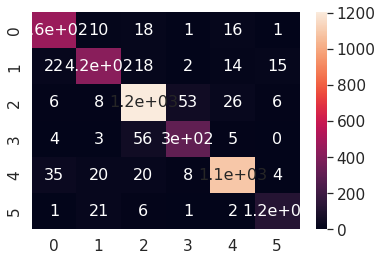

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred_invrt = le.inverse_transform(y_pred)
y_test_invrt = le.inverse_transform(y_test)

conf_mat = confusion_matrix(y_test_invrt, y_pred_invrt)
df_cm = pd.DataFrame(conf_mat, range(6), range(6))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, precision_recall_fscore_support

print('\nClassification Report : ')
print(classification_report(y_test_invrt, y_pred_invrt))


Classification Report : 
              precision    recall  f1-score   support

       anger       0.87      0.91      0.89       510
        fear       0.87      0.85      0.86       487
         joy       0.91      0.92      0.92      1304
        love       0.82      0.81      0.82       367
     sadness       0.95      0.93      0.94      1179
    surprise       0.82      0.80      0.81       153

    accuracy                           0.90      4000
   macro avg       0.87      0.87      0.87      4000
weighted avg       0.90      0.90      0.90      4000



In [ ]:
import pickle

filename = 'finalized_model.sav'
pickle.dump(grid, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


0.8995
